In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
def extract_features(image):
    h, w, _ = image.shape

    # Grayscale version for variance and edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Center region
    center = image[h//4:3*h//4, w//4:3*w//4]
    avg_center_color = np.mean(center)

    # Full square stats
    avg_square_color = np.mean(image)
    color_contrast_center = abs(avg_center_color - avg_square_color)
    color_variance = np.var(image)

    # Top vs bottom
    top_half = image[:h//2, :]
    bottom_half = image[h//2:, :]
    mean_top = np.mean(top_half)
    mean_bottom = np.mean(bottom_half)
    contrast_top_bottom = abs(mean_top - mean_bottom)

    # Edge strength using Sobel
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=3)
    edge_strength = np.mean(np.abs(sobel))

    return [
        avg_center_color,
        avg_square_color,
        color_contrast_center,
        color_variance,
        mean_top,
        mean_bottom,
        contrast_top_bottom,
        edge_strength
    ]

# Directories
base_dir = "labeled_squares"
classes = ["0", "1"]  # 0: no piece, 1: piece
data = []

for label in classes:
    path = os.path.join(base_dir, label)
    for fname in tqdm(os.listdir(path), desc=f"Processing label {label}"):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
        fpath = os.path.join(path, fname)
        image = cv2.imread(fpath)
        if image is None:
            continue
        features = extract_features(image)
        data.append(features + [int(label)])

# Convert to DataFrame
columns = [
    "avg_center_color", "avg_square_color", "color_contrast_center", 
    "color_variance", "mean_top", "mean_bottom", 
    "contrast_top_bottom", "edge_strength", "label"
]

df = pd.DataFrame(data, columns=columns)

# Save to CSV or use directly
df.to_csv("square_features.csv", index=False)
print("✅ Features saved to square_features.csv")


Processing label 1: 100%|██████████| 692/692 [00:00<00:00, 1277.53it/s]

✅ Features saved to square_features.csv



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       502
           1       0.96      0.96      0.96       138

    accuracy                           0.98       640
   macro avg       0.98      0.97      0.97       640
weighted avg       0.98      0.98      0.98       640



C:\Users\Cristiano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [10:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


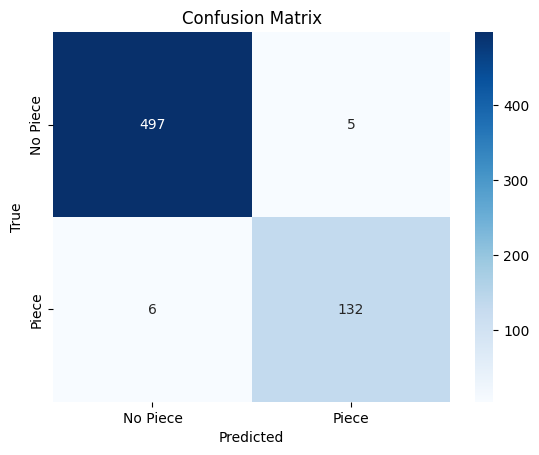

In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load features
df = pd.read_csv("square_features.csv")

# Split features and label
X = df.drop("label", axis=1)
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# Train XGBoost model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Piece", "Piece"], yticklabels=["No Piece", "Piece"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
model.save_model("xgb_piece_detector.json")